# Introduction Part 2 Adversarial Auto Encoders

The revised version seeks to extract information from the images such as regional density & Geometric shape. This will be done with feature extracters and Adverserial Auto Encoders. Adversarial Autoencoders (AAEs) are a type of generative model that combine elements of both autoencoders and generative adversarial networks (GANs). Autoencoders are neural networks that are trained to reconstruct their input data, while GANs consist of a generator network that generates samples from random noise and a discriminator network that tries to distinguish between real and generated samples. AAEs introduce an adversarial component to the autoencoder architecture by adding a discriminator network, similar to GANs. The discriminator's role is to differentiate between the encoded representations produced by the autoencoder and a prior distribution (typically a Gaussian distribution) that represents "normal" or "expected" data. This adversarial setup encourages the autoencoder to generate encoded representations that resemble samples from the prior distribution. The main idea behind AAEs in anomaly detection is to train the autoencoder to learn a low-dimensional representation of the input data, and then use the discriminator to distinguish between normal and anomalous samples based on the encoded representations. By doing so, the autoencoder can capture the underlying structure of the normal data distribution and identify samples that deviate significantly from it as anomalies. 

In part 2, since we are dealing with adversarial autoencoders we will not be dealing with class imbalance . Class imbalance refers to a situation where the classes in a dataset are not represented equally, with one or more classes having significantly fewer samples than others. In the context of unsupervised learning, where the goal is to discover patterns, structure, or anomalies in the data without explicit class labels, class imbalance is not as directly relevant as it is in supervised learning tasks. In unsupervised learning, the focus is on learning representations, clustering, or anomaly detection without relying on class labels. Class imbalance typically affects the performance of supervised learning algorithms that require labeled data for training, such as classification or supervised anomaly detection. Thus, we will not be doing class imbalance 

**Our Objective:** To identify different types of wafer map failure pattern automatically instead of manual work, so that the semi-conductor fabrication can improve on the yield of wafers manufacturing process.

Here, we list all reference:

[1]Anomaly Detection with Adversarial Dual Autoencoders [paper downloas link](https://arxiv.org/ftp/arxiv/papers/1902/1902.06924.pdf) <br>
[2]WaferMap 811k https://www.kaggle.com/code/ashishpatel26/wm-811k-wafermap

In [2]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os
print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

['LSWMD.pkl']


**Step2: Prepare your data**

* **Data Selection & Preprocessing: ** Consider what data is available, what data is missing and what data can be removed. Also, organize your selected data by formatting, cleaning and sampling from it.

Here is a simple **checklist** provided for you to understand your dataset better:

* Data summary
* Target distribution
* Missing value check
* Others

>** Data summary**

In [3]:
df=pd.read_pickle("../input/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


* The dataset comprises **811,457 wafer maps**, along with additional information such as **wafer die size**, **lot name** and **wafer index**. 

* The training / test set were already split by domain experts, but in this kernel we ignore this info and we re-divided the dataset into training set and test set by hold-out mehtod which will be introduced in later section.

>Target distribution

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [4]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps ** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

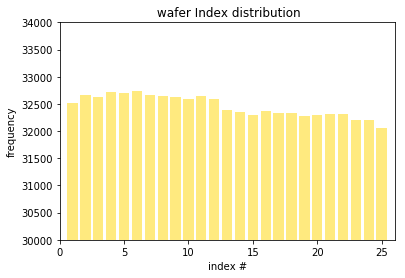

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

* The figure shows that not all lots have perfect 25 wafer maps and it may caused by **sensor failure** or other unknown problems.

* Fortunately, we do not need wafer index feature in our classification so we can just drop the variable. 

In [5]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.


In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
157270,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1620.0,lot10160,[],[],"(37, 55)"
243254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1638.0,lot15128,[],[],"(41, 51)"
198452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot12670,[],[],"(64, 71)"
443736,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",733.0,lot27148,[],[],"(31, 31)"
444868,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot27274,[],[],"(49, 39)"


In [7]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [8]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 

* For this reason, we must do **data tranformation** (feature extraction) to make input the same dim and the method will be introducedin the following section.

>**Missing value check**

* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [9]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [10]:
tol_wafers = df.shape[0]
tol_wafers

811457

In [15]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(25519, 172950, 147431)

# FAST DENOISNG 
The fastNlMeansDenoising() function is a powerful tool for reducing noise in images. It implements the Non-local Means Denoising algorithm in a computationally efficient manner. The goal of this algorithm is to remove noise while preserving the important details and structures in the image. To achieve this, the algorithm compares patches of pixels within the image that are similar in terms of their content. By identifying these similar patches, it can estimate the clean pixel value for each location in the image. This estimation is done by averaging the pixel values of the similar patches, effectively smoothing out the noise and providing a cleaner representation of the underlying image.

The purpose of applying denoising techniques like fastNlMeansDenoising() is to improve the quality of the input data before feeding it to a model. Noise in images can introduce unnecessary variations and distortions that can negatively impact the performance of models, especially those that rely on visual features or patterns.By reducing the noise, the denoising process aims to enhance the relevant features and make them more distinguishable for subsequent feature extraction or analysis. This helps in preventing the model from being confused by irrelevant noise patterns and improves the accuracy and reliability of the feature extraction step.

Overall, the use of denoising techniques like fastNlMeansDenoising() is an important preprocessing step to ensure that the input data provided to the model is clean and devoid of unwanted noise, leading to improved performance and more accurate feature extraction.

In [13]:
import cv2
from concurrent import futures

def denoise_wafer_map(wafer_map):
    return cv2.fastNlMeansDenoising(wafer_map, None, 0.75, 3, 3)

# Define the number of cores/threads to use
num_cores = 4

# Define a function for denoising a single wafer map using fastNlMeansDenoising
def denoise_single_wafer(wafer_map):
    return denoise_wafer_map(wafer_map)

# Create a ThreadPoolExecutor with the desired number of threads
executor = futures.ThreadPoolExecutor(max_workers=num_cores)

# Create a list to store the denoised wafer maps
denoised_wafer_maps = []

# Define a helper function for denoising and appending the results
def denoise_and_append(wafer_map):
    denoised_map = denoise_single_wafer(wafer_map)
    denoised_wafer_maps.append(denoised_map)

# Process each wafer map in parallel using the ThreadPoolExecutor
for wafer_map in df_withpattern['waferMap']:
    executor.submit(denoise_and_append, wafer_map)

# Wait for all the tasks to complete
executor.shutdown()

# Replace the original wafer maps with the denoised versions in the dataframe
df_withpattern['waferMap'] = denoised_wafer_maps


# 

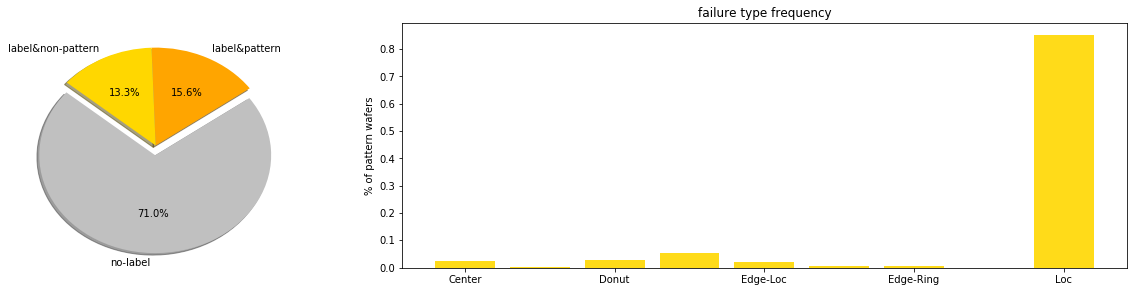

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

# A Picture is worth a thousand words

* The best way to observe the raw data is to do ** data visualization**.

* We show the **first 100 samples** with pattern labeled from our datasets.
- There is now less noise in the wafer maps


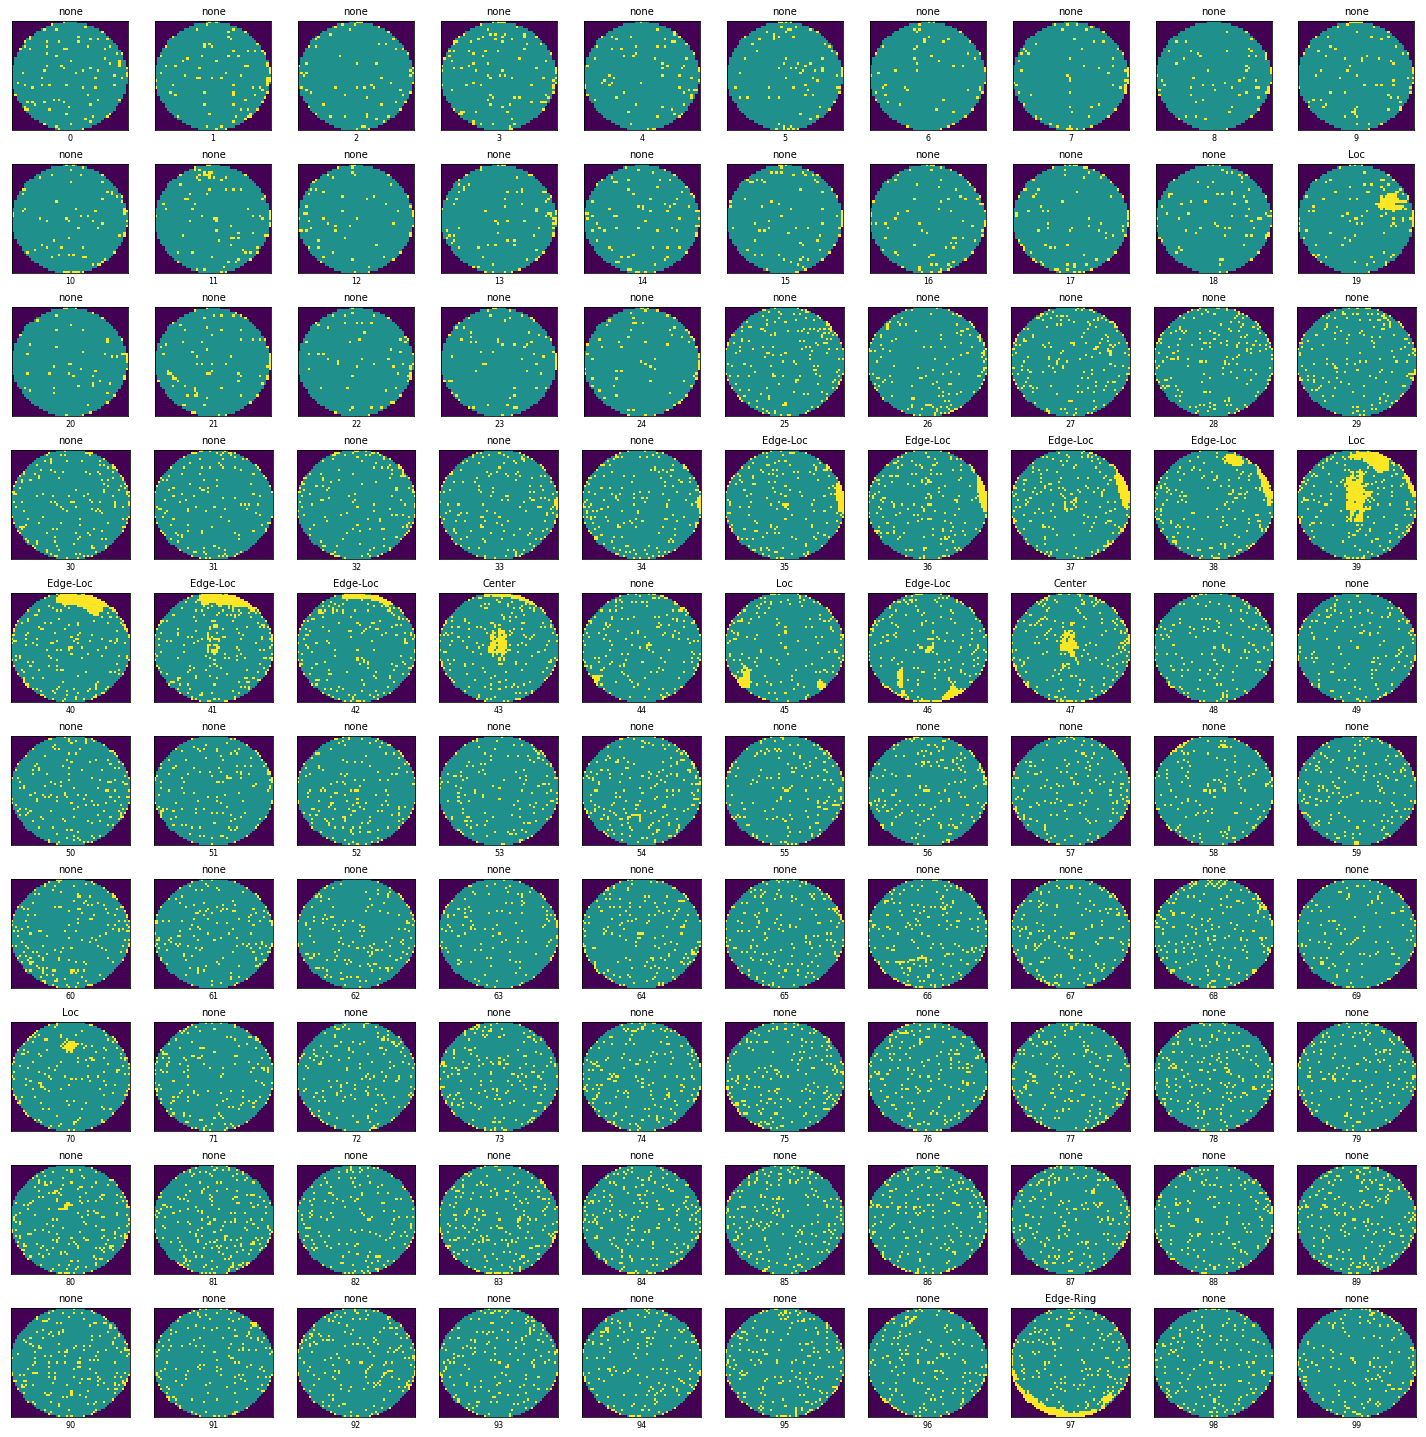

In [13]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

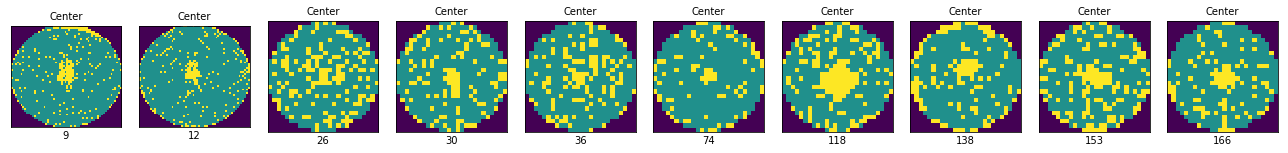

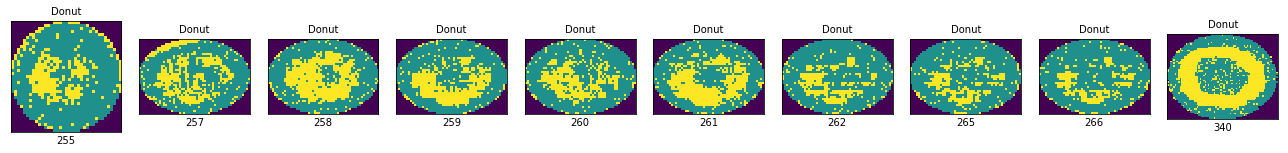

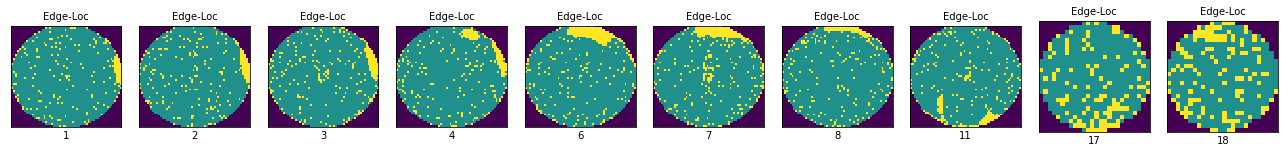

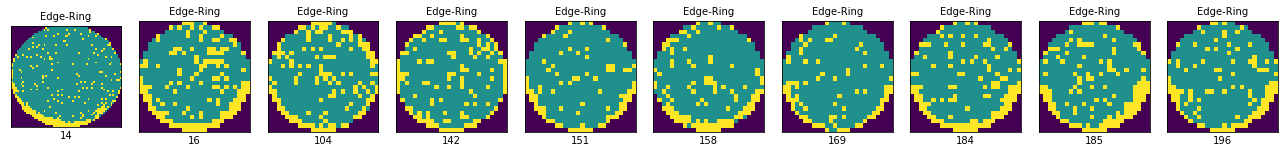

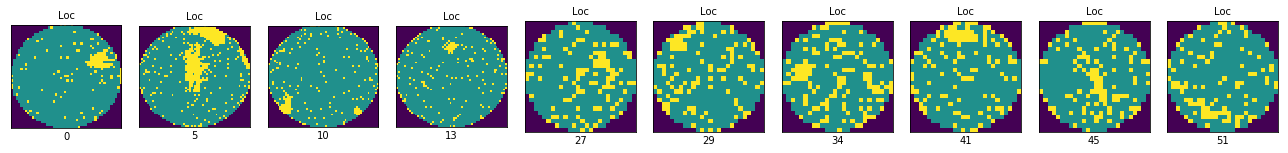

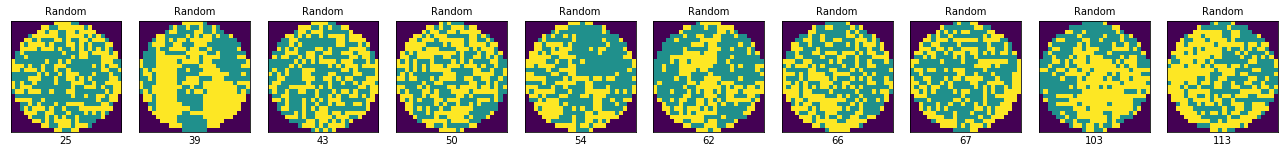

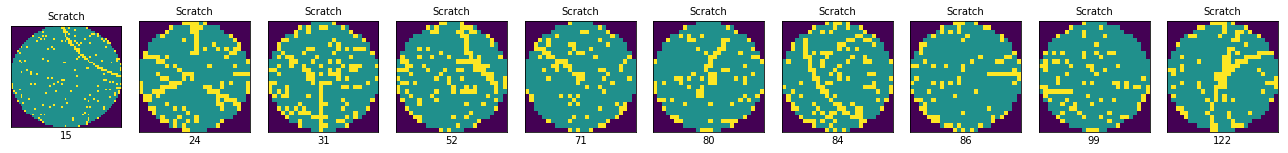

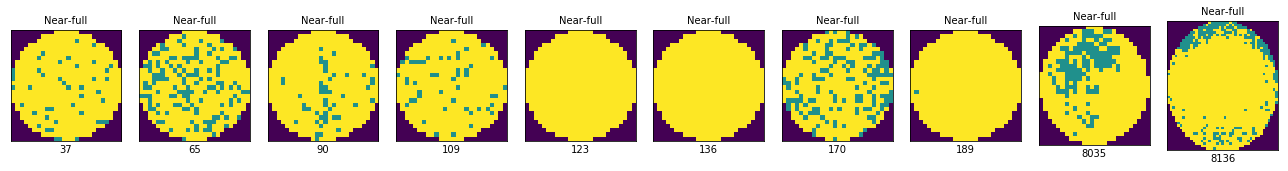

In [16]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withlabel.waferMap[df_withlabel.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withlabel.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_withlabel.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

* From each failure type, we selected the most **typical failure pattern** for visualization.

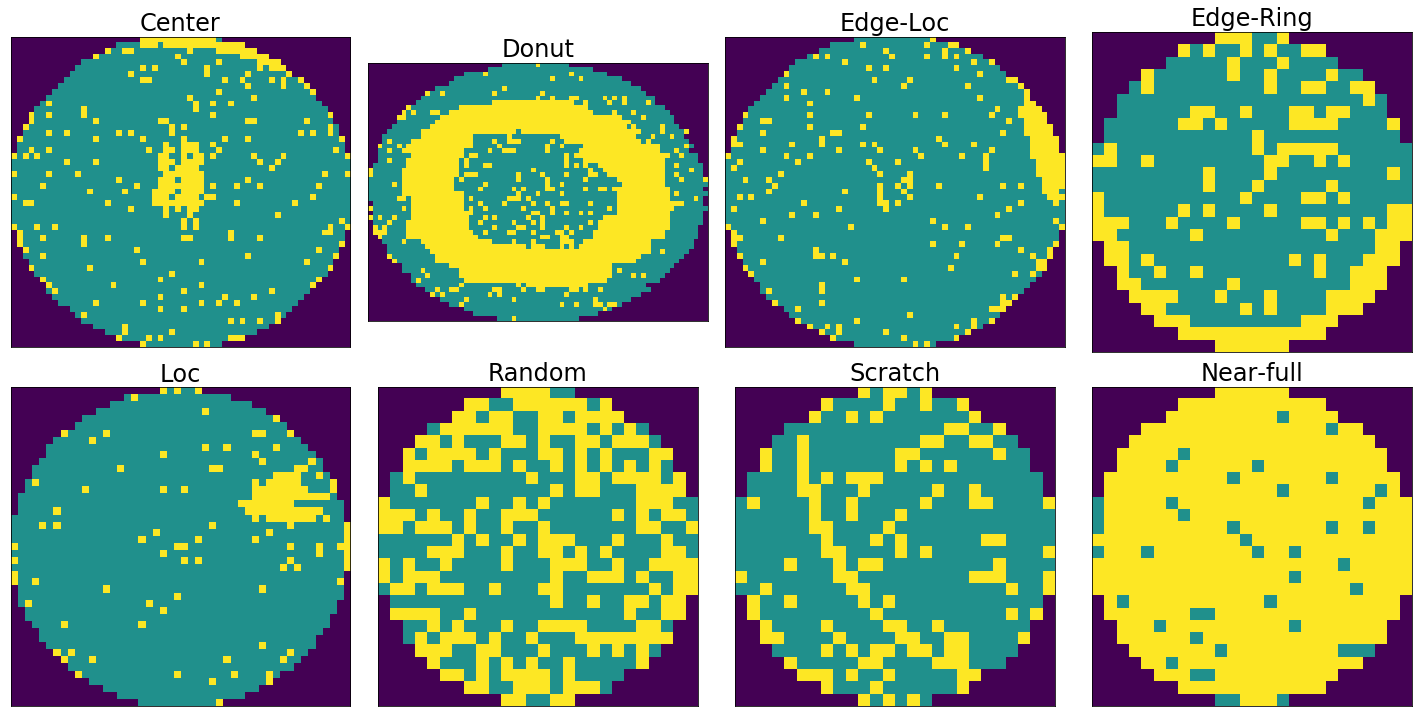

In [17]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withlabel.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

# Step 2: Preparing our data (Cont.)

* **Data Transformation:** Transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.


In [18]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

## Density-based Features (13)

* Divided wafer map into 13 parts and computed defects density accordingly. The 13 regions includes the inner 9 same regions and the top, bottom, left and right regions. 

* For each failure type, it has different density distribution patterns. For example, the center one of the inner 9 regions  will have high defects density for Center failure type.

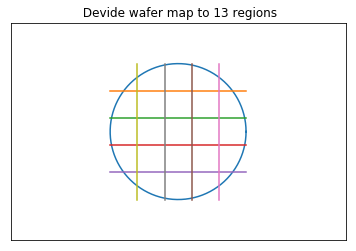

In [19]:
# illustration of 13 regions
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [20]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  


df = []

def find_regions(x):
      
        rows=np.size(x,axis=0)
        cols=np.size(x,axis=1)
    # we get divide by 0 error if we do not run this, some wafer do not have any defects, thus they have 0 "important points"& need to be delt with, the configuation below will solve that issue but may add some noise to the data as the configuration might not reprsent the data point well enough
        if cols < 16  :
            cols = 48
        else:
            ind1=np.arange(0,rows,rows//5)
            ind2=np.arange(0,cols,cols//5)

            reg1=x[ind1[0]:ind1[1],:]
            reg3=x[ind1[4]:,:]
            reg4=x[:,ind2[0]:ind2[1]]
            reg2=x[:,ind2[4]:]

            reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
            reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
            reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
            reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
            reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
            reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
            reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
            reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
            reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]

            fea_reg_den = []
            fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
            df.append(fea_reg_den)
            return fea_reg_den

In [21]:
df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['fea_reg']=df_withpattern.waferMap.apply(find_regions)

In [22]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

In [23]:
import concurrent.futures
import numpy as np
from scipy import interpolate
from skimage.transform import radon

def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis=1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind='cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew) / 100  # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind='cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew) / 100  # use interpolation function returned by `interp1d`
    return ynew

# Create a ProcessPoolExecutor with the desired number of processes (cores)
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Use submit() to schedule the tasks concurrently
    futures_mean = [executor.submit(cubic_inter_mean, row['waferMap']) for _, row in df_withpattern_copy.iterrows()]
    futures_std = [executor.submit(cubic_inter_std, row['waferMap']) for _, row in df_withpattern_copy.iterrows()]

    # Collect the results as they become available
    results_mean = [future.result() for future in futures_mean]
    results_std = [future.result() for future in futures_std]

# Assign the results to the respective columns in the DataFrame
df_withpattern_copy['fea_cub_mean'] = results_mean
df_withpattern_copy['fea_cub_std'] = results_std

## Radon-based feature (interpolate from row mean) **
The Radon transform is the projection of the image intensity along a radial line oriented at a specific angle.

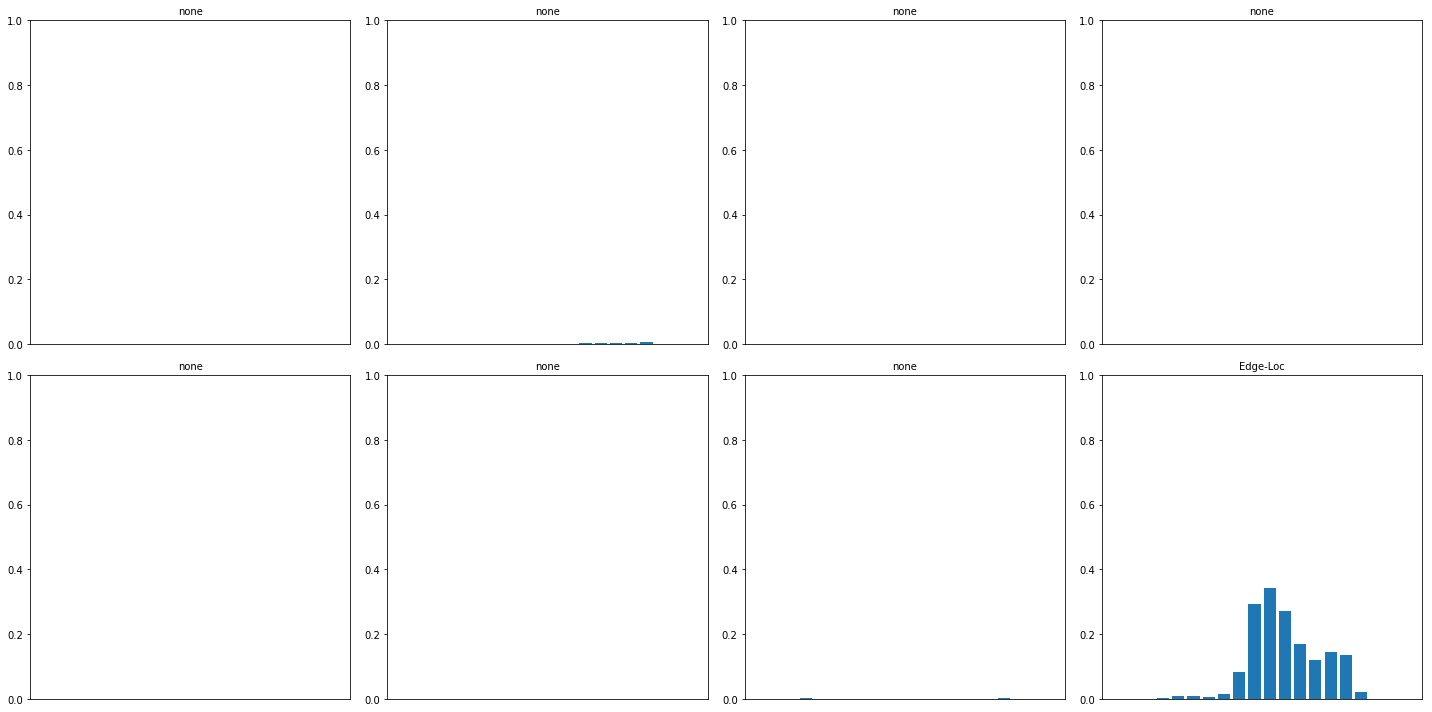

In [24]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

In [25]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [26]:
df_withpattern_copy.fea_geom.shape#donut

(172950,)

# Combine all features together

* density-based features: 13

* radon-based features: 40

* geom-based features: 6

* in total: 13+40+6=59   

In [27]:
df_all=df_withpattern_copy.copy()

b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(df)[0:172946],np.array(b)[0:172946],np.array(c)[0:172946],np.array(d)[0:172946]),axis=1) #59 in total

In [28]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

# Step 3: Choose algorithms

In [30]:
# We change the problem from multi class to binary classification through this process, 8 == no defects , 1== defects. If i = 8, i =0 else is 1
label_1 = []
for i in label :
    if i==8:
        i = 0
        label_1.append(i)
    else:
        i=1
        label_1.append(i)

In [31]:
label_1 = np.array(label_1)

# Step 4. Split & Train

In [384]:
import theano
from theano import tensor as T
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils

# Some of our data is corrputed so our x and y doesnt match , its only a few labels so shouldnt cause much issues
X = fea_all
y = label_1[0:172946]

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42


Training target statistics: Counter({0: 110403, 1: 19306})
Testing target statistics: Counter({0: 37028, 1: 6209})


# Creation of AAEs & Bayes Optimization 

Bayesian optimization is a method for finding the best set of parameters for a machine learning model. It works by creating a probability model of how the model's performance is affected by changes in its parameters. For example, suppose we have a machine learning model that we want to train on a dataset, and it has several parameters that can be adjusted, such as the learning rate or the number of hidden layers. Bayesian optimization can help us find the best combination of parameter values that will give us the highest accuracy on our test set. The method works by iteratively selecting parameter values to test based on their probability of leading to an improvement in the model's performance. As more iterations are performed, the probability model is updated to incorporate the results of previous tests, allowing the optimization process to focus on the most promising parameter values. Overall, Bayesian optimization can help us save time and resources by efficiently searching through a large space of parameter values to find the best combination for our model.


In [41]:
import tensorflow
import numpy as np
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from skopt import forest_minimize

# Set the input dimension
# Creation of the AAE Model Link :  || https://arxiv.org/pdf/1902.06924 ||  https://paperswithcode.com/paper/anomaly-detection-with-adversarial-dual
input_dim = 59
train_data = X_train
test_data = X_test

# Define the encoder architecture
input_data = Input(shape=(input_dim,))
encoded = Dense(32)(input_data)
encoded = LeakyReLU()(encoded)
encoded = Dense(16)(encoded)
encoded = LeakyReLU()(encoded)
encoded = Dense(8)(encoded)
encoded = LeakyReLU()(encoded)
encoded = Dense(4)(encoded)
encoded = LeakyReLU()(encoded)

# Define the decoder architecture
decoded = Dense(4)(encoded)
decoded = LeakyReLU()(decoded)
decoded = Dense(8)(decoded)
decoded = LeakyReLU()(decoded)
decoded = Dense(16)(decoded)
decoded = LeakyReLU()(decoded)
decoded = Dense(32)(decoded)
decoded = LeakyReLU()(decoded)
decoded = Dense(input_dim)(decoded)

# Define the discriminator architecture
discriminated = Dense(8)(encoded)
discriminated = LeakyReLU()(discriminated)
discriminated = Dense(4)(discriminated)
discriminated = LeakyReLU()(discriminated)
discriminated = Dense(2)(discriminated)
discriminated = LeakyReLU()(discriminated)
discriminated = Dense(1, activation='sigmoid')(discriminated)

# Combine the encoder and decoder into an autoencoder model
autoencoder = Model(input_data, decoded)

# Combine the encoder and discriminator into an adversarial autoencoder model
adversarial_autoencoder = Model(input_data, [decoded, discriminated])

# Compile the models
autoencoder.compile(optimizer=Adam(), loss='mse')
adversarial_autoencoder.compile(optimizer=Adam(),
                                loss=['mse', 'binary_crossentropy'],
                                loss_weights=[0.9, 0.1])

num_samples = train_data.shape[0]

# Define the parameter search space for Bayesian optimization
search_space = [
    (5, 20),  # Number of epochs
    (16, 64) ,# batch_size
    (85.5,86.5) # 
]

# Define the objective function for Bayesian optimization
def objective_function(params):
    epochs, batch_size,threshold_MSE = params

    # Train the adversarial autoencoder
    adversarial_autoencoder.fit(train_data, [train_data, np.ones((num_samples, 1))],
                                epochs=epochs, batch_size=batch_size, verbose=0)

    # Use the trained model for anomaly detection on the test data
    decoded_data, discriminator_predictions = adversarial_autoencoder.predict(test_data)
    mse = np.mean(np.power(test_data - decoded_data, 2), axis=1)
    threshold = np.percentile(mse, threshold_MSE)
    anomalies = np.where(mse > threshold)[0]

    return -len(anomalies)  # Return negative number of anomalies for maximization

# Perform Bayesian optimization to tune the hyperparameters
res = forest_minimize(objective_function, search_space, n_calls=10, random_state=42)

# Get the best hyperparameters
best_params = {
    'epochs': res.x[0],
    'batch_size': res.x[1],
    'threshold_MSE': res.x[2]
    
}

print("Best hyperparameters:", best_params)

# Update the models with the best hyperparameters
adversarial_autoencoder.fit(train_data, [train_data, np.ones((num_samples, 1))],
                            epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Use the trained model for anomaly detection on the test data
decoded_data, discriminator_predictions = adversarial_autoencoder.predict(train_data)
mse = np.mean(np.power(train_data - decoded_data, 2), axis=1)
threshold = np.percentile(mse, best_params['threshold_MSE'])
anomalies = np.where(mse > threshold)[0]

print("Anomaly detection results:")
if len(anomalies) > 0:
    print("Anomalies detected at indices:", anomalies.shape)
else:
    print("No anomalies detected.")


Best hyperparameters: {'epochs': 14, 'batch_size': 37, 'threshold_MSE': 85.50706630521972}
Anomaly detection results:
Anomalies detected at indices: (18799,)


In [207]:
adversarial_autoencoder.fit(train_data, [train_data, np.ones((num_samples, 1))],
                            epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

# Use the trained model for anomaly detection on the test data
decoded_data, discriminator_predictions = adversarial_autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - decoded_data, 2), axis=1)
threshold = np.percentile(mse, best_params['threshold_MSE'])
anomalies = np.where(mse > threshold)[0]

In [208]:
print("Anomaly detection results:")
if len(anomalies) > 0:
    print("Anomalies detected at indices:", anomalies.shape)
else:
    print("No anomalies detected.")


Anomaly detection results:
Anomalies detected at indices: (6267,)


# Ensemble 
Ensemble Method refers to a machine learning approach that enhances predictive accuracy and mitigates overfitting by combining multiple models, such as decision trees or neural networks. In an ensemble, each model is trained on a distinct subset of the training data or employs a different algorithm. During the prediction phase, the ensemble harmonizes the outputs of each model to minimize errors and enhance overall accuracy

In [356]:
# The contaminsation rate is determined by the amount of anomalies found in the datasetes over the whole dataset 
contamination= 19306 / (19306 + 110403)

In [357]:
contamination

0.14884086686351758

### Isolation Forest
Counter({0: 110403, 1: 19306}

In [358]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [359]:
from sklearn import preprocessing
# scaling all data to the same scale
fea_all_ISO = preprocessing.StandardScaler().fit_transform(X_train)

In [360]:
#Specifying Params and fitting thedata
clf=IsolationForest(n_estimators=100, max_samples="auto", contamination=contamination,\
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(X_train)

df_num = pd.DataFrame() # puttting all outputs of all models in this dataframe 
pred = clf.decision_function(X_test)
df_num['anomaly_Iso']=pred
print(pred) # -1 indicates anomaly

[ 0.1655629   0.11306007  0.12899005 ... -0.02339316  0.03258665
  0.00423529]


In [361]:
pred = clf.predict(X_test)

print(Counter(pred))

Counter({1: 37042, -1: 6195})


### Adversarial Auto Encoder

In [362]:
# Since we are predicting on training data for all models then this should run
df_num['anomaly_AAE'] = mse

In [389]:
#  reconstruction error
print("Reconstruction error:")
print(np.mean(mse))

Reconstruction error:
0.18020296419022955


### Simple Neural Network
Optional to run, This brings up the ensemble model accuracy by 6%. 

In [385]:
# Create a sequential model
import tensorflow as tf
model = tf.keras.models.Sequential()
# Add layers to the model
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train,y_train,epochs=10, batch_size=512, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
129709/129709 [==============================] - 3s 24us/step - loss: 0.3913 - acc: 0.8767
Epoch 2/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2655 - acc: 0.9139
Epoch 3/10
129709/129709 [==============================] - 2s 14us/step - loss: 0.2510 - acc: 0.9206
Epoch 4/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2430 - acc: 0.9241
Epoch 5/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2391 - acc: 0.9262
Epoch 6/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2368 - acc: 0.9277
Epoch 7/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2347 - acc: 0.9284
Epoch 8/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2330 - acc: 0.9299
Epoch 9/10
129709/129709 [==============================] - 1s 10us/step - loss: 0.2307 - acc: 0.9302
Epoch 10/10
43237/43237 [==============================] - 3s 73us/step
Test Loss:

In [386]:
predictions = model.predict(X_test)
df_num['anomaly_NN'] = predictions

Predictions:
 [[0.03892656]
 [0.07076168]
 [0.0617381 ]
 ...
 [0.13395509]
 [0.9762723 ]
 [0.52170235]]


# XGB

XGBoost (Extreme Gradient Boosting) is a powerful machine learning algorithm that uses an ensemble of decision trees to make accurate predictions. It combines the strengths of gradient boosting and tree-based models to optimize predictive performance. XGBoost is known for its sped, scalability, and ability to handle complex datasets. It employs a a gradient boosting framework, where each new tree is built to correct the errors made by the the previous trees. This iteratve process results in a highly accurate and robust predictive model.

In [366]:
import numpy as np
import xgboost as xgb


# Create DMatrix for training data, saves ,memory and time
dtrain = xgb.DMatrix(X_train, label=y_train)

# Set the parameters for XGBoost
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 10,
    'n_estimators':25
}

# Train the XGBoost model
num_rounds = 25
xgb_model = xgb.train(params, dtrain, num_rounds)


# Create DMatrix for test data
dtest = xgb.DMatrix(X_test)

# Make predictions using the trained model
y_pred = xgb_model.predict(dtest)

# Print the predicted probabilities
print("Predicted probabilities:")
print(y_pred)


Predicted probabilities:
[0.02954516 0.03522818 0.04033466 ... 0.04202143 0.99831474 0.89962703]


In [367]:
# Make predictions using the trained model
y_pred = xgb_model.predict(dtest)
df_num['anomaly_XGB'] = np.array(y_pred).astype('float64')

In [368]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate precision
precision = precision_score(y_test, y_pred_binary)

# Calculate recall
recall = recall_score(y_test, y_pred_binary)

# Calculate F1-score
f1 = f1_score(y_test, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.9321527138914444
Recall: 0.6527621195039459
F1-score: 0.767831770389315


In [369]:
df_num.head()

,anomaly_Iso,anomaly_AAE,anomaly_NN,anomaly_XGB
0,0.165563,0.001274,0.039427,0.029545
1,0.113060,0.027645,0.048197,0.035228
2,0.128990,0.004184,0.057138,0.040335
3,0.167968,0.001344,0.039926,0.027172
4,0.158681,0.002075,0.060732,0.038046


# Do ensemble outputs predictions

In [370]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

In [371]:
# Splitting the data into train and test sets
X = df_num  # Features (input columns)
y =  y_test
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the train and test sets
print("X_train:\n", X_train.shape)
print("X_test:\n", X_test.shape)
print("y_train:\n", y_train.shape)
print("y_test:\n", y_test.shape)

X_train:
 (34589, 4)
X_test:
 (8648, 4)
y_train:
 (34589,)
y_test:
 (8648,)


In [372]:

# Add layers to the model
model = tf.keras.models.Sequential()
# Add layers to the model
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='relu'))
#model.add(tf.keras.layers.Dense(2, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=256, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/25
34589/34589 [==============================] - 3s 75us/step - loss: 0.6091 - binary_accuracy: 0.9189
Epoch 2/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2442 - binary_accuracy: 0.9420
Epoch 3/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2033 - binary_accuracy: 0.9428
Epoch 4/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2030 - binary_accuracy: 0.9431
Epoch 5/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2018 - binary_accuracy: 0.9432
Epoch 6/25
34589/34589 [==============================] - 1s 20us/step - loss: 0.2019 - binary_accuracy: 0.9429
Epoch 7/25
34589/34589 [==============================] - 1s 22us/step - loss: 0.2017 - binary_accuracy: 0.9433
Epoch 8/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2016 - binary_accuracy: 0.9433
Epoch 9/25
34589/34589 [==============================] - 1s 19us/step - loss: 0.2015 - binary_accuracy:

In [382]:

y_pred = model.predict([X_test])
# Define a threshold probability value
threshold = 0.5

# Convert probabilities to class labels
y_pred_classes = np.zeros_like(y_pred, dtype=int)
y_pred_classes[y_pred > threshold] = 1

score1 = accuracy_score(y_test,y_pred_classes)
score2 = precision_score(y_test,y_pred_classes)
score3= recall_score(y_test,y_pred_classes)
print("\n")
print("Accuracy is ",round(score1*100,2),"%")
print("Precision is ",round(score2,2))
print("Recall is ",round(score3,2))
print('F1 Score:',f1_score(y_test, y_pred_classes))



Accuracy is  94.39 %
Precision is  0.94
Recall is  0.66
F1 Score: 0.7715496938294866


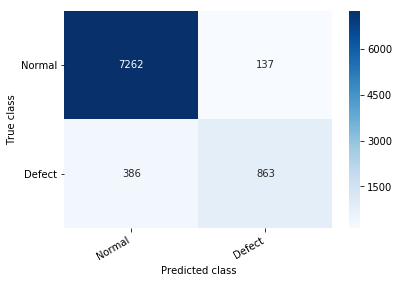

In [379]:
class_names = ["Normal","Defect"]
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class');

cm = confusion_matrix(y_test
                      , y_pred_classes)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)